In [1]:
using HTTP
using JSON
using DataFrames
using Dates
using TimeSeries

In [2]:
include("env.jl")

"VVp9vMTjNvSEUqJJuqpRLw5r4oUq2uFGbX2VipCE"

In [3]:
function wgetStock(sym::String)
    fromTime =  Dates.format(now()-Day(500), "yyyy-mm-ddTHH:MM:SS")
    @show fromTime
    headers = ["APCA-API-KEY-ID" => ENV["APCA-API-KEY-ID"], "APCA-API-SECRET-KEY" => ENV["APCA-API-SECRET-KEY"] ]
    url_query = "https://data.alpaca.markets/v1/bars/day?symbols="*sym*"&after="*fromTime*"&limit=500"
    raw_response = HTTP.request("GET", url_query, headers)
    rsp = JSON.parse(String(raw_response.body))
    df2 = DataFrame(t = Int[],h = Float32[],l = Float32[],o = Float32[],c = Float32[],v = Float32[] )
    for (sym,v) in rsp
        for q in v
            push!(df2,q)
        end
    end
    transform!(df2, :t => ( x -> Dates.unix2datetime.(x) ) => :ondate)
    DataFrames.rename!(df2,:h => :High)
    DataFrames.rename!(df2,:l => :Low)
    DataFrames.rename!(df2,:o => :Open)
    DataFrames.rename!(df2,:c => :Close)
    DataFrames.rename!(df2,:v => :Volume)
    sort!(df2,order(:ondate))
    return select(df2,[:Open,:Close,:High,:Low,:Volume,:ondate])
end

wgetStock (generic function with 1 method)

In [6]:
tick1="GLD"
df1 = wgetStock(tick1)
tick2="IAU"
df2 = wgetStock(tick2)

fromTime = "2020-01-17T22:24:07"
fromTime = "2020-01-17T22:24:12"


,Open,Close,High,Low,Volume,ondate
,Float32,Float32,Float32,Float32,Float32,DateTime
1,12.67,12.6925,12.715,12.6317,1.53733e7,2019-06-04T04:00:00
2,12.8,12.73,12.82,12.66,2.12638e7,2019-06-05T04:00:00
3,12.77,12.77,12.83,12.76,1.08123e7,2019-06-06T04:00:00
4,12.86,12.84,12.91,12.81,1.61607e7,2019-06-07T04:00:00
5,12.72,12.715,12.73,12.68,5.36394e6,2019-06-10T04:00:00
6,12.68,12.69,12.72,12.66,8.821e6,2019-06-11T04:00:00
7,12.73,12.76,12.8,12.73,1.52359e7,2019-06-12T04:00:00
8,12.78,12.84,12.86,12.77,2.00298e7,2019-06-13T04:00:00
9,12.9,12.835,12.95,12.8013,1.97872e7,2019-06-14T04:00:00


In [7]:
using Pkg 
Pkg.add("StatsBase")
using StatsBase
Pkg.add("HypothesisTests")
using HypothesisTests

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [8]:

using Plots
function testStationary(df)
    y = autocor(df,1:20)
    display(bar(y))
    y = pacf(df,1:20)
    display(bar(y))
    ADFTest(df,:none,1)
end

testStationary (generic function with 1 method)

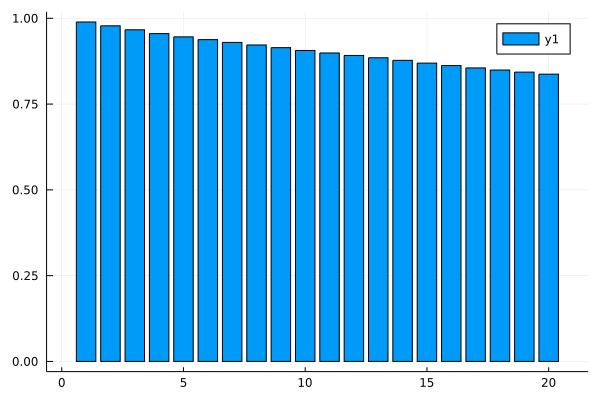

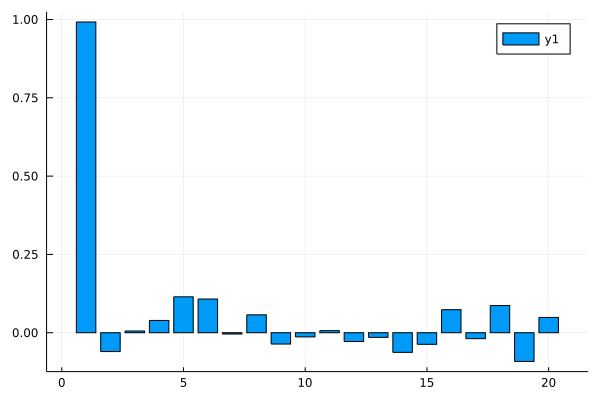

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          0.000523185

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.9261

Details:
    sample size in regression:          498
    number of lags:                     1
    ADF statistic:                      1.07721
    Critical values at 1%, 5%, and 10%: [-2.57023 -1.94155 -1.6163]


In [9]:
testStationary(df1[!,:Close])

In [10]:
Pkg.add("TimeSeries")
using TimeSeries

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [11]:
ta1 = TimeArray(df1;timestamp = :ondate)
ta2 = TimeArray(df2;timestamp = :ondate)
merge(ta1[:Close],ta2[:Close],colnames = [:Close1,:Close2])

498×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-06-06T04:00:00 to 2021-05-28T04:00:00
│                     │ Close1 │ Close2  │
├─────────────────────┼────────┼─────────┤
│ 2019-06-06T04:00:00 │ 125.89 │ 12.77   │
│ 2019-06-07T04:00:00 │ 126.59 │ 12.84   │
│ 2019-06-10T04:00:00 │ 125.33 │ 12.715  │
│ 2019-06-11T04:00:00 │ 125.2  │ 12.69   │
│ 2019-06-12T04:00:00 │ 125.82 │ 12.76   │
│ 2019-06-13T04:00:00 │ 126.6  │ 12.84   │
│ 2019-06-14T04:00:00 │ 126.56 │ 12.835  │
│ 2019-06-17T04:00:00 │ 126.48 │ 12.825  │
│ 2019-06-18T04:00:00 │ 127.04 │ 12.88   │
│ 2019-06-19T04:00:00 │ 127.89 │ 12.965  │
│ 2019-06-20T04:00:00 │ 131.12 │ 13.295  │
│ 2019-06-21T04:00:00 │ 132.0  │ 13.39   │
   ⋮
│ 2021-05-14T04:00:00 │ 172.68 │ 17.57   │
│ 2021-05-17T04:00:00 │ 174.72 │ 17.7785 │
│ 2021-05-18T04:00:00 │ 175.01 │ 17.81   │
│ 2021-05-19T04:00:00 │ 175.16 │ 17.8189 │
│ 2021-05-20T04:00:00 │ 175.96 │ 17.9    │
│ 2021-05-21T04:00:00 │ 176.04 │ 17.91   │
│ 2021-05-24T04:00:00 │ 176.38 │ 35.8

In [20]:
pct1 = percentchange(ta1[:Close])
pct2 = percentchange(ta2[:Close])
pct = merge(pct1,pct2)
TimeSeries.rename!(pct,:Close => :Close1)
TimeSeries.rename!(pct,:Close_1 => :Close2)
dif = TimeSeries.rename(pct[:Close1] .- pct[:Close2], :Close1_Close2 => :Diff) 
data = merge(pct,dif)
df = DataFrame(data[3:9])
current = DataFrame(data[10])
@show df[3,:Close1]
@show size(current)
current[1,:Close1]

df[3, :Close1] = 0.0061994237f0
size(current) = (1, 4)


0.025256062f0

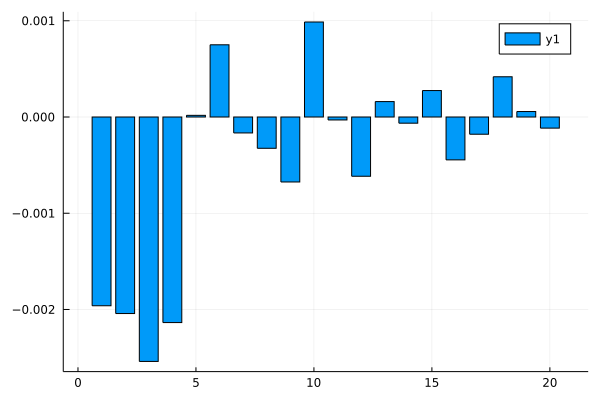

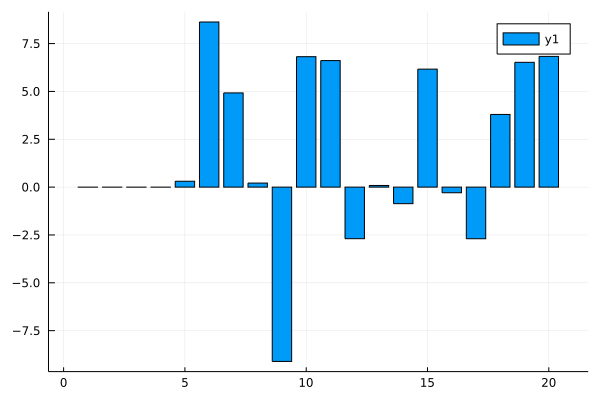

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.999954

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-26

Details:
    sample size in regression:          497
    number of lags:                     1
    ADF statistic:                      -15.7319
    Critical values at 1%, 5%, and 10%: [-2.57024 -1.94155 -1.6163]


In [11]:
testStationary(data[!,:Close])

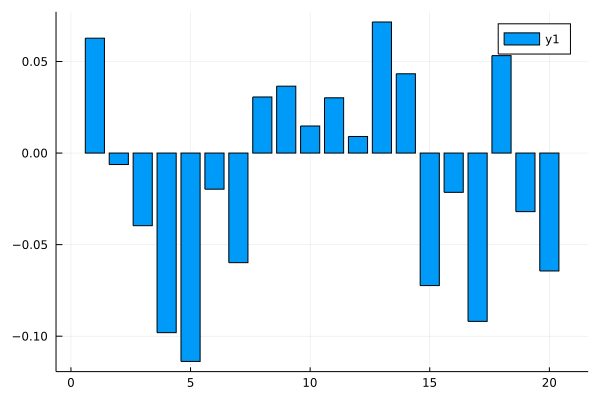

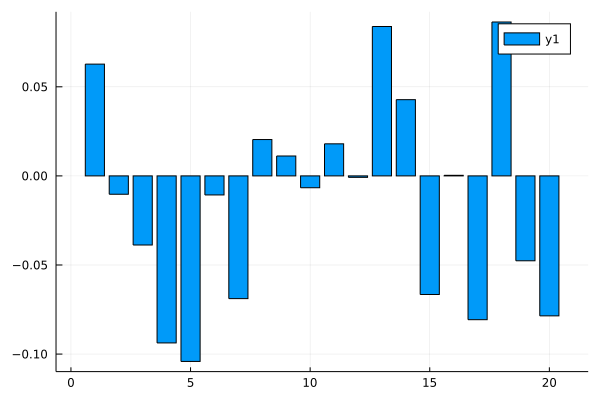

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.937131

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-26

Details:
    sample size in regression:          497
    number of lags:                     1
    ADF statistic:                      -15.2811
    Critical values at 1%, 5%, and 10%: [-2.57024 -1.94155 -1.6163]


In [21]:
testStationary(DataFrame(pct1[:Close])[!,:Close])

In [12]:
for (row_index,row) in enumerate(eachrow(pct))
    @show row.timestamp
    @show row.Close
    @show row_index
    
end

row.timestamp = DateTime("2019-06-07T04:00:00")
row.Close = 0.0055600624f0
row_index = 1
row.timestamp = DateTime("2019-06-10T04:00:00")
row.Close = -0.009953225f0
row_index = 2
row.timestamp = DateTime("2019-06-11T04:00:00")
row.Close = -0.0010370596f0
row_index = 3
row.timestamp = DateTime("2019-06-12T04:00:00")
row.Close = 0.004951776f0
row_index = 4
row.timestamp = DateTime("2019-06-13T04:00:00")
row.Close = 0.0061994237f0
row_index = 5
row.timestamp = DateTime("2019-06-14T04:00:00")
row.Close = -0.00031609306f0
row_index = 6
row.timestamp = DateTime("2019-06-17T04:00:00")
row.Close = -0.00063208624f0
row_index = 7
row.timestamp = DateTime("2019-06-18T04:00:00")
row.Close = 0.0044276696f0
row_index = 8
row.timestamp = DateTime("2019-06-19T04:00:00")
row.Close = 0.006690852f0
row_index = 9
row.timestamp = DateTime("2019-06-20T04:00:00")
row.Close = 0.025256062f0
row_index = 10
row.timestamp = DateTime("2019-06-21T04:00:00")
row.Close = 0.0067114932f0
row_index = 11
row.timestamp = D

row.Close = 0.0031836536f0
row_index = 115
row.timestamp = DateTime("2019-11-19T05:00:00")
row.Close = 0.0005050981f0
row_index = 116
row.timestamp = DateTime("2019-11-20T05:00:00")
row.Close = 0.0002885281f0
row_index = 117
row.timestamp = DateTime("2019-11-21T05:00:00")
row.Close = -0.0054055452f0
row_index = 118
row.timestamp = DateTime("2019-11-22T05:00:00")
row.Close = -0.0018117685f0
row_index = 119
row.timestamp = DateTime("2019-11-25T05:00:00")
row.Close = -0.0050089853f0
row_index = 120
row.timestamp = DateTime("2019-11-26T05:00:00")
row.Close = 0.0050342013f0
row_index = 121
row.timestamp = DateTime("2019-11-27T05:00:00")
row.Close = -0.0052993055f0
row_index = 122
row.timestamp = DateTime("2019-11-29T05:00:00")
row.Close = 0.0062766736f0
row_index = 123
row.timestamp = DateTime("2019-12-02T05:00:00")
row.Close = -0.0006530536f0
row_index = 124
row.timestamp = DateTime("2019-12-03T05:00:00")
row.Close = 0.009797574f0
row_index = 125
row.timestamp = DateTime("2019-12-04T05:00:

row.Close = 0.0067441366f0
row_index = 228
row.timestamp = DateTime("2020-05-04T04:00:00")
row.Close = 0.0038191106f0
row_index = 229
row.timestamp = DateTime("2020-05-05T04:00:00")
row.Close = 0.003929208f0
row_index = 230
row.timestamp = DateTime("2020-05-06T04:00:00")
row.Close = -0.012238338f0
row_index = 231
row.timestamp = DateTime("2020-05-07T04:00:00")
row.Close = 0.015345781f0
row_index = 232
row.timestamp = DateTime("2020-05-08T04:00:00")
row.Close = -0.006070235f0
row_index = 233
row.timestamp = DateTime("2020-05-11T04:00:00")
row.Close = -0.006169758f0
row_index = 234
row.timestamp = DateTime("2020-05-12T04:00:00")
row.Close = 0.004044584f0
row_index = 235
row.timestamp = DateTime("2020-05-13T04:00:00")
row.Close = 0.0088374205f0
row_index = 236
row.timestamp = DateTime("2020-05-14T04:00:00")
row.Close = 0.009162183f0
row_index = 237
row.timestamp = DateTime("2020-05-15T04:00:00")
row.Close = 0.005521225f0
row_index = 238
row.timestamp = DateTime("2020-05-18T04:00:00")
row.

row_index = 341
row.timestamp = DateTime("2020-10-13T04:00:00")
row.Close = -0.015839627f0
row_index = 342
row.timestamp = DateTime("2020-10-14T04:00:00")
row.Close = 0.0032075716f0
row_index = 343
row.timestamp = DateTime("2020-10-15T04:00:00")
row.Close = 0.0037583227f0
row_index = 344
row.timestamp = DateTime("2020-10-16T04:00:00")
row.Close = -0.0035765432f0
row_index = 345
row.timestamp = DateTime("2020-10-19T04:00:00")
row.Close = 0.00044880444f0
row_index = 346
row.timestamp = DateTime("2020-10-20T04:00:00")
row.Close = 0.004877024f0
row_index = 347
row.timestamp = DateTime("2020-10-21T04:00:00")
row.Close = 0.0078104185f0
row_index = 348
row.timestamp = DateTime("2020-10-22T04:00:00")
row.Close = -0.009964083f0
row_index = 349
row.timestamp = DateTime("2020-10-23T04:00:00")
row.Close = -0.0010623054f0
row_index = 350
row.timestamp = DateTime("2020-10-26T04:00:00")
row.Close = -0.0006716379f0
row_index = 351
row.timestamp = DateTime("2020-10-27T04:00:00")
row.Close = 0.002912463

row.timestamp = DateTime("2021-03-23T04:00:00")
row.Close = -0.0073003024f0
row_index = 452
row.timestamp = DateTime("2021-03-24T04:00:00")
row.Close = 0.0033372173f0
row_index = 453
row.timestamp = DateTime("2021-03-25T04:00:00")
row.Close = -0.003387423f0
row_index = 454
row.timestamp = DateTime("2021-03-26T04:00:00")
row.Close = 0.0028426442f0
row_index = 455
row.timestamp = DateTime("2021-03-29T04:00:00")
row.Close = -0.01183178f0
row_index = 456
row.timestamp = DateTime("2021-03-30T04:00:00")
row.Close = -0.017368305f0
row_index = 457
row.timestamp = DateTime("2021-03-31T04:00:00")
row.Close = 0.015517186f0
row_index = 458
row.timestamp = DateTime("2021-04-01T04:00:00")
row.Close = 0.012311769f0
row_index = 459
row.timestamp = DateTime("2021-04-05T04:00:00")
row.Close = -0.0004938813f0
row_index = 460
row.timestamp = DateTime("2021-04-06T04:00:00")
row.Close = 0.008214652f0
row_index = 461
row.timestamp = DateTime("2021-04-07T04:00:00")
row.Close = -0.0028179444f0
row_index = 462


In [25]:
N = length(pct)

499

In [33]:
for i in 2:N
    @show values(pct[i-1:i,:Close])
end

values(pct[i - 1:i, :Close]) = Float32[0.0055600624; -0.009953225]
values(pct[i - 1:i, :Close]) = Float32[-0.009953225; -0.0010370596]
values(pct[i - 1:i, :Close]) = Float32[-0.0010370596; 0.004951776]
values(pct[i - 1:i, :Close]) = Float32[0.004951776; 0.0061994237]
values(pct[i - 1:i, :Close]) = Float32[0.0061994237; -0.00031609306]
values(pct[i - 1:i, :Close]) = Float32[-0.00031609306; -0.00063208624]
values(pct[i - 1:i, :Close]) = Float32[-0.00063208624; 0.0044276696]
values(pct[i - 1:i, :Close]) = Float32[0.0044276696; 0.006690852]
values(pct[i - 1:i, :Close]) = Float32[0.006690852; 0.025256062]
values(pct[i - 1:i, :Close]) = Float32[0.025256062; 0.0067114932]
values(pct[i - 1:i, :Close]) = Float32[0.0067114932; 0.014696737]
values(pct[i - 1:i, :Close]) = Float32[0.014696737; 0.0019411783]
values(pct[i - 1:i, :Close]) = Float32[0.0019411783; -0.009165464]
values(pct[i - 1:i, :Close]) = Float32[-0.009165464; -0.0009775149]
values(pct[i - 1:i, :Close]) = Float32[-0.0009775149; 0.002

values(pct[i - 1:i, :Close]) = Float32[-0.0015699448; 0.002050592]
values(pct[i - 1:i, :Close]) = Float32[0.002050592; 0.0008868333]
values(pct[i - 1:i, :Close]) = Float32[0.0008868333; 0.00027278805]
values(pct[i - 1:i, :Close]) = Float32[0.00027278805; 0.0023162924]
values(pct[i - 1:i, :Close]) = Float32[0.0023162924; 0.005846358]
values(pct[i - 1:i, :Close]) = Float32[0.005846358; 0.006892964]
values(pct[i - 1:i, :Close]) = Float32[0.006892964; -0.0087255]
values(pct[i - 1:i, :Close]) = Float32[-0.0087255; 0.005281518]
values(pct[i - 1:i, :Close]) = Float32[0.005281518; -0.0001349358]
values(pct[i - 1:i, :Close]) = Float32[-0.0001349358; 0.0061975047]
values(pct[i - 1:i, :Close]) = Float32[0.0061975047; -0.006694695]
values(pct[i - 1:i, :Close]) = Float32[-0.006694695; -0.013210006]
values(pct[i - 1:i, :Close]) = Float32[-0.013210006; 0.0010925535]
values(pct[i - 1:i, :Close]) = Float32[0.0010925535; 0.0057312544]
values(pct[i - 1:i, :Close]) = Float32[0.0057312544; 0.0024419988]
va

values(pct[i - 1:i, :Close]) = Float32[0.011917955; -0.011559391]
values(pct[i - 1:i, :Close]) = Float32[-0.011559391; 0.017155709]
values(pct[i - 1:i, :Close]) = Float32[0.017155709; 0.0023865523]
values(pct[i - 1:i, :Close]) = Float32[0.0023865523; 0.0009736984]
values(pct[i - 1:i, :Close]) = Float32[0.0009736984; -0.012918229]
values(pct[i - 1:i, :Close]) = Float32[-0.012918229; -0.008104209]
values(pct[i - 1:i, :Close]) = Float32[-0.008104209; 0.0029258532]
values(pct[i - 1:i, :Close]) = Float32[0.0029258532; -0.0019264715]
values(pct[i - 1:i, :Close]) = Float32[-0.0019264715; 0.009375861]
values(pct[i - 1:i, :Close]) = Float32[0.009375861; -0.0032785912]
values(pct[i - 1:i, :Close]) = Float32[-0.0032785912; 0.0]
values(pct[i - 1:i, :Close]) = Float32[0.0; 0.00789404]
values(pct[i - 1:i, :Close]) = Float32[0.00789404; -0.0021211032]
values(pct[i - 1:i, :Close]) = Float32[-0.0021211032; 0.0026160066]
values(pct[i - 1:i, :Close]) = Float32[0.0026160066; -0.0053277635]
values(pct[i - 

values(pct[i - 1:i, :Close]) = Float32[0.010751412; -0.007536952]
values(pct[i - 1:i, :Close]) = Float32[-0.007536952; -0.0060019847]
values(pct[i - 1:i, :Close]) = Float32[-0.0060019847; 0.0070240465]
values(pct[i - 1:i, :Close]) = Float32[0.0070240465; -0.0044053034]
values(pct[i - 1:i, :Close]) = Float32[-0.0044053034; 0.016039811]
values(pct[i - 1:i, :Close]) = Float32[0.016039811; 0.0062905885]
values(pct[i - 1:i, :Close]) = Float32[0.0062905885; -0.0028250767]
values(pct[i - 1:i, :Close]) = Float32[-0.0028250767; 0.0035563617]
values(pct[i - 1:i, :Close]) = Float32[0.0035563617; 0.009850542]
values(pct[i - 1:i, :Close]) = Float32[0.009850542; -0.006423733]
values(pct[i - 1:i, :Close]) = Float32[-0.006423733; -0.0039508766]
values(pct[i - 1:i, :Close]) = Float32[-0.0039508766; 0.0027044562]
values(pct[i - 1:i, :Close]) = Float32[0.0027044562; -0.0025173873]
values(pct[i - 1:i, :Close]) = Float32[-0.0025173873; 0.0030645502]
values(pct[i - 1:i, :Close]) = Float32[0.0030645502; -0.0

In [ ]:

function BuyOrSell(ta1,ta2,i,lookback)
    pct1 = percentchange(ta1[:Close])
    pct2 = percentchange(ta2[:Close])
    pct = merge(pct1,pct2)
    TimeSeries.rename!(pct,:Close => :Close1)
    TimeSeries.rename!(pct,:Close_1 => :Close2)
    dif = TimeSeries.rename(pct[:Close1] .- pct[:Close_2], :Close1_Close2 => :Diff) 
    data = merge(pct,dif)
    
    df = DataFrame(data[i-lookbak:i-1])
    current = DataFrame(data[i])
    
    mean1 = 
    std1 =  
    mean12 = 
    std12 = 
    mean2 = 
    std2 = 
    p1 = current[1,:Close1]
    p2 = current[1,:Close2]
    dif12 = current[1,:Diff]

    act1 = 0
    act2 = 0
    thd2 = 2
    thd1 = 1
    
    if p1 >= mean1 + thd2*std1
        act1 = -1
        if p2 >= mean2 + thd2*std2
            act2 = -1
        elseif p2 > mean2 - thd2*std2
                if dif12 > mean12 + thd1*std12
                    act2 = 1
                elseif dif12 < mean12 - thd1*std12
                    act2 = -1
                end    
        else
            act2 = 1
        end
    elseif p1 > mean1 - thd2*std1
        if p2 >= mean2 + thd2*std2
            act2 = -1
            if dif12 > mean12 + thd1*std12
                    act1 = 1
            elseif dif12 < mean12 - thd1*std12
                    act1 = -1
            end  
        elseif p2 > mean2 - thd2*std2
            if dif12 > mean12 + thd1*std12
                    act1 = -1
                    act2 = 1
            elseif dif12 < mean12 - thd1*std12
                    act1 = 1
                    act2 = -1
            end        
        else
            act2 = 1
            if dif12 > mean12 + thd1*std12
                    act1 = -1
            elseif dif12 < mean12 - thd1*std12
                    act1 = 1
            end     
        end
    else
        act1 = 1
        if p2 >= mean2 + thd2*std2
            act2 = -1
        elseif p2 > mean2 - thd2*std2
            if dif12 > mean12 + thd1*std12
                    act2 = 1
            elseif dif12 < mean12 - thd1*std12
                    act2 = -1
            end       
        else
            act2 = 1
        end
    end
    return (act1,act2)
end

In [43]:
[i-2+1:i for i in 1:2]

2-element Vector{UnitRange{Int64}}:
 0:1
 1:2